# **Dataiku Data Scientist Technical Assessment**
### Author : Jules Boistard
### Submission date : January 18th, 2022
___

#### **#1 : Exploratory data analysis**

##### **1.1 : Importing the dataset**

In [1]:
# Read the train and test files
import pandas as pd
import re

metadata = open("data/census_income_metadata.txt")
col_names = [re.findall("\(([^\)]+)\)", line)[0] for line in metadata.readlines()[81:121]]
col_names.append("total person income")

train = pd.read_csv("data/census_income_learn.csv", header=None, sep=", ", na_values="?", usecols=[i for i in range(42) if i!=24], names=col_names)
test = pd.read_csv("data/census_income_test.csv", header=None, sep=", ", na_values="?", usecols=[i for i in range(42) if i!=24], names=col_names)

'''
Note : column #24 in the csv corresponds to the instance weight.
While it will be kept for exploratory data analysis, we will later on remove it to train the classifiers.
It is therefore treated separately in this section and added as last column.
'''
train["instance weight"] = pd.read_csv("data/census_income_learn.csv", header=None, sep=", ", na_values="?", usecols=[24])
test["instance weight"] = pd.read_csv("data/census_income_test.csv", header=None, sep=", ", na_values="?", usecols=[24])

e:\dataiku_assessment\venv\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [2]:
train.sample(3)

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,total person income,instance weight
15302,77,Not in universe,0,0,9th grade,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,26,94,- 50000.,2113.49
50634,80,Not in universe,0,0,Some college but no degree,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,NaN,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.,4991.97
146115,32,Private,35,17,11th grade,0,Not in universe,Married-civilian spouse present,Finance insurance and real estate,Sales,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.,2386.86


##### **1.2 : Identify duplicates and conflicts in data**

As stated in the metadata file, the train and test sets respectively contains a fairly large number of duplicates or conflictided instances, precisely :
- 46716 obervations for the train set
- 20936 observations for the test set

This can be easily verified, as shown below

In [3]:
nb_dc_train = train.drop(["instance weight", "total person income"], axis=1).duplicated().sum()
nb_dc_test  = test.drop(["instance weight", "total person income"], axis=1).duplicated().sum()
print("Number of duplicates/conflicts in train set : ", nb_dc_train)
print("Number of duplicates/conflicts in test set : ", nb_dc_test)
print ("Total number of duplicates : ", nb_dc_train + nb_dc_test)

Number of duplicates/conflicts in train set :  46716
Number of duplicates/conflicts in test set :  20936
Total number of duplicates :  67652


We need to adress this issue right away, as it could potentially hurt our analysis and machine learning model a lot later on. We can go a little bit further by dissociating actual duplicates (identical observations with same target) from conflicts (identical observations with different targets)

In [4]:
dc_train = train.drop(["instance weight", "total person income"], axis=1).duplicated()
duplicates_train = train.drop(["instance weight"], axis=1).duplicated()
conflicts_train = (dc_train & ~duplicates_train)

dc_test= test.drop(["instance weight", "total person income"], axis=1).duplicated()
duplicates_test = test.drop(["instance weight"], axis=1).duplicated()
conflicts_test = (dc_test & ~duplicates_test)

print("Number of duplicate/conflicts over whole dataset : ", dc_train.sum() + dc_test.sum())
print("- Including ", duplicates_train.sum(), " duplicates in train set")
print("- Including ", conflicts_train.sum(), " conflicts in train set")
print("- Including ", duplicates_test.sum(), " duplicates in train set")
print("- Including ", conflicts_test.sum(), " conflicts in train set")


Number of duplicate/conflicts over whole dataset :  67652
- Including  46627  duplicates in train set
- Including  89  conflicts in train set
- Including  20898  duplicates in train set
- Including  38  conflicts in train set


Let us look at an example of a duplicate entry (in the train set)

In [5]:
pd.set_option('display.max_columns', 50)

random_duplicate_idx = duplicates_train[duplicates_train].sample(random_state=5).index
ref_entry = train.iloc[random_duplicate_idx]
df_sample = train.copy()
for col in train.drop(["instance weight"], axis=1).columns:
    ref_value = ref_entry[col].iloc[0]
    if not pd.isnull(ref_value):
        df_sample = df_sample[df_sample[col] == ref_value]
df_sample

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,total person income,instance weight
137373,13,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,South,Utah,Child <18 never marr not in subfamily,Child under 18 never married,MSA to MSA,Same county,Same county,No,Yes,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,2738.79
197426,13,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,South,Utah,Child <18 never marr not in subfamily,Child under 18 never married,MSA to MSA,Same county,Same county,No,Yes,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,3040.58


We can see from the above example that there are 2 identical entries, **target variable included** (it could be a lot more than 2).

To delete duplicates, we can merge these lines and add up the instance weights, in the training set and test set separately

In [6]:
train_without_duplicates = train.groupby([col for col in train.drop(["instance weight"], axis=1).columns],dropna=False)["instance weight"].sum().reset_index()
test_without_duplicates = test.groupby([col for col in test.drop(["instance weight"], axis=1).columns],dropna=False)["instance weight"].sum().reset_index()


# Quick verification that we have exactly the initial number of entries minus the previously identified number of duplicates in each set
print("Dropped entries for train set : ", len(train) - len(train_without_duplicates))
print("Dropped entries for test set : ", len(test) - len(test_without_duplicates))

Dropped entries for train set :  46627
Dropped entries for test set :  20898


Let us now look at an example of conflicting instances in data (in the train set still)

In [7]:
# Since indexes have been reset in the previous operation, we need to re-compute the indexes of conflicting instances
conflicts_train = train_without_duplicates.drop(["instance weight", "total person income"], axis=1).duplicated()
conflicts_test = test_without_duplicates.drop(["instance weight", "total person income"], axis=1).duplicated()

print(conflicts_train.sum())
print(conflicts_test.sum())

89
38


In [37]:
random_conflict_idx = conflicts_train[conflicts_train].sample(random_state=5).index
ref_entry = train_without_duplicates.iloc[random_conflict_idx]
df_sample = train_without_duplicates.copy()
for col in train_without_duplicates.drop(["instance weight", "total person income"], axis=1).columns:
    ref_value = ref_entry[col].iloc[0]
    if not pd.isnull(ref_value):
        df_sample = df_sample[df_sample[col] == ref_value]
df_sample

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,total person income,instance weight
123946,58,Private,32,18,Some college but no degree,0,Not in universe,Married-civilian spouse present,Wholesale trade,Sales,White,All other,Male,Not in universe,Not in universe,Full-time schedules,0,0,0,Joint both under 65,Not in universe,Not in universe,Householder,Householder,NaN,NaN,NaN,Not in universe under 1 year old,NaN,6,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.,3349.55
123947,58,Private,32,18,Some college but no degree,0,Not in universe,Married-civilian spouse present,Wholesale trade,Sales,White,All other,Male,Not in universe,Not in universe,Full-time schedules,0,0,0,Joint both under 65,Not in universe,Not in universe,Householder,Householder,NaN,NaN,NaN,Not in universe under 1 year old,NaN,6,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,50000+.,2285.73


This time, every thing is identical except for the target value (total person income). Since we also want to avoid conflicting instances, we can keep the target class matching the highest total instance weight across all the observations.

***Note** : at this point, there will only be conflicts between pairs of observations, because we already merged the 100% identical observations (target class included), and added up the instance weights*

In [38]:
train_without_dc = train_without_duplicates.sort_values(
    "instance weight",
    ascending=False
).drop_duplicates(
    subset=list(train_without_duplicates.drop(["instance weight", "total person income"],axis=1).columns),
    keep="first"
)

test_without_dc = test_without_duplicates.sort_values(
    "instance weight",
    ascending=False
).drop_duplicates(
    subset=list(test_without_duplicates.drop(["instance weight", "total person income"],axis=1).columns),
    keep="first"
)

# Quick verification that we have exactly the initial number of entries minus the previously identified number of conflicts in each set
print("Dropped entries for train set : ", len(train_without_duplicates) - len(train_without_dc))
print("Dropped entries for test set : ", len(test_without_duplicates) - len(test_without_dc))

Dropped entries for train set :  89
Dropped entries for test set :  38


In [39]:
print("Train set drop rate : ", 100 * round(1-len(train_without_dc)/len(train), 2), "%")
print("Test set drop rate : ", 100 * round(1-len(test_without_dc)/len(test), 2), "%")

Train set drop rate :  23.0 %
Test set drop rate :  21.0 %


We dropped a little less than a quarter of our initial dataset, which is acceptable.

Note that provided we have domain expertise and the ability to collect extra data, we could end up with extra features allowing us to tell these observations apart, and keep them

We will save the "cleaned" train and test sets for future pre processing and model training

For the rest of exploratory data analysis, let us concatenate them to look at statistics on the whole dataset

In [40]:
train_without_dc.to_csv("data/train_clean.csv", index=False)
test_without_dc.to_csv("data/test_clean.csv", index=False)

data = pd.concat([train_without_dc, test_without_dc], ignore_index=True)

##### **1.3 : Looking into missing values**

<AxesSubplot:>

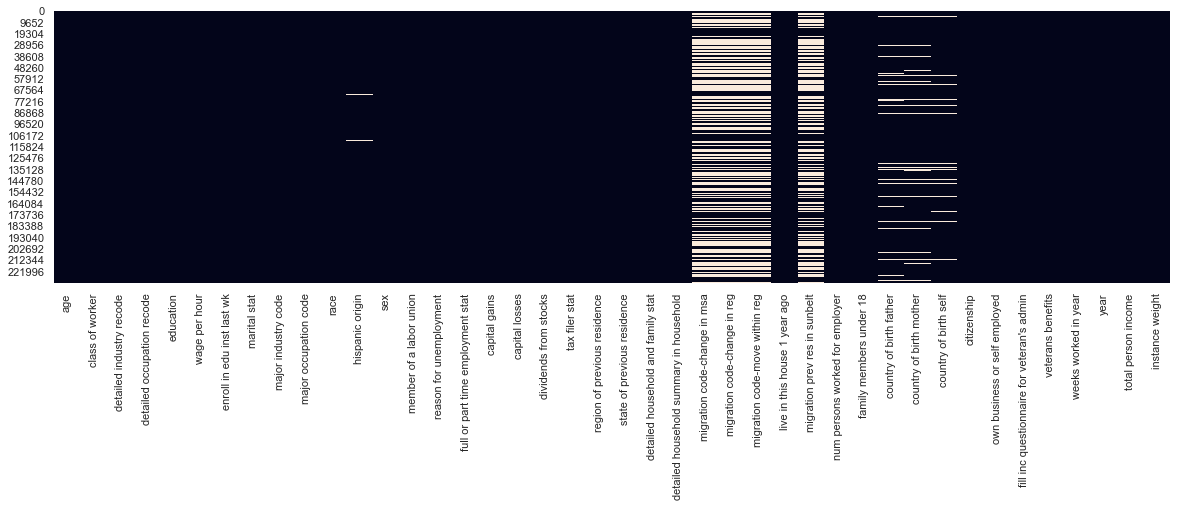

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

plt.figure(figsize=(20,5))
sns.heatmap(data.isna(), cbar=False)

In [28]:
nan_rate = data.isna().sum() / len(data)
nan_rate.sort_values(ascending=False).head(10)

migration code-change in msa      0.491053
migration code-change in reg      0.491053
migration code-move within reg    0.491053
migration prev res in sunbelt     0.491053
country of birth father           0.041833
country of birth mother           0.037900
country of birth self             0.021832
hispanic origin                   0.005349
state of previous residence       0.004425
citizenship                       0.000000
dtype: float64

From the above, we can separate the 9 variables with missing values into 2 groups :
- Top 4 : they have near 50% of missing values, so we will probably drop them altogether in preprocessing later on
- Bottom 5 : they have a rather low rate of missing values, therefore imputation could be a viable option

This is for pre-processing and model training. For EDA, we will drop the 4 columns with too many missing values **and** drop all remaing observations with missing values in other columns

In [43]:
# Identify categorical columns in the dataset (pre-identified in metadata file)
num_cols = ["age", "wage per hour", "capital gains", "capital losses", "dividends from stocks", "num persons worked for employer", "weeks worked in year"]
cat_cols = [col for col in train.columns if col not in num_cols and col not in ["total person income", "instance weight"]]

In [44]:
cols_to_drop = ["migration code-change in msa", "migration code-change in reg", "migration code-move within reg", "migration prev res in sunbelt"]
cat_cols = list(set(cat_cols).difference(set(cols_to_drop)))
train_without_dc_and_nan = train_without_dc.drop(cols_to_drop, axis=1).dropna()
test_without_dc_and_nan = test_without_dc.drop(cols_to_drop, axis=1).dropna()

data = pd.concat([train_without_dc_and_nan, test_without_dc_and_nan], ignore_index=True)

train_without_dc_and_nan.to_csv("data/train_clean_no_nan.csv", index=False)
test_without_dc_and_nan.to_csv("data/test_clean_no_nan.csv", index=False)

print("Clean train set size : ", len(train_without_dc_and_nan))
print("Clean test set size : ", len(test_without_dc_and_nan))

Clean train set size :  143442
Clean test set size :  74047


##### **1.4 : Continuous variables distribution**

In [45]:
# Look at descriptive stats for numerical features
data[num_cols].describe()

,age,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,weeks worked in year
count,217489.000000,217489.000000,217489.000000,217489.000000,217489.000000,217489.000000,217489.000000
mean,39.423327,72.926084,551.130071,47.649950,246.943519,2.560672,30.304236
std,19.434228,311.502834,5246.098471,305.496793,2181.541502,2.403479,23.718906
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,0.000000,0.000000,0.000000,0.000000,2.000000,46.000000
75%,52.000000,0.000000,0.000000,0.000000,0.000000,5.000000,52.000000
max,90.000000,9999.000000,99999.000000,4608.000000,99999.000000,6.000000,52.000000


We can detect a couple of things from the above statistics :
- Wage, capital gains (and losses ?) and dividends seem to have been capped @ 9999 and 99999
- The nb of persons working for employer seem strangely low, which seems to indicate that the data have been altered
- The average worked weeks seem very low, probably accounting for children and retired people in the sample

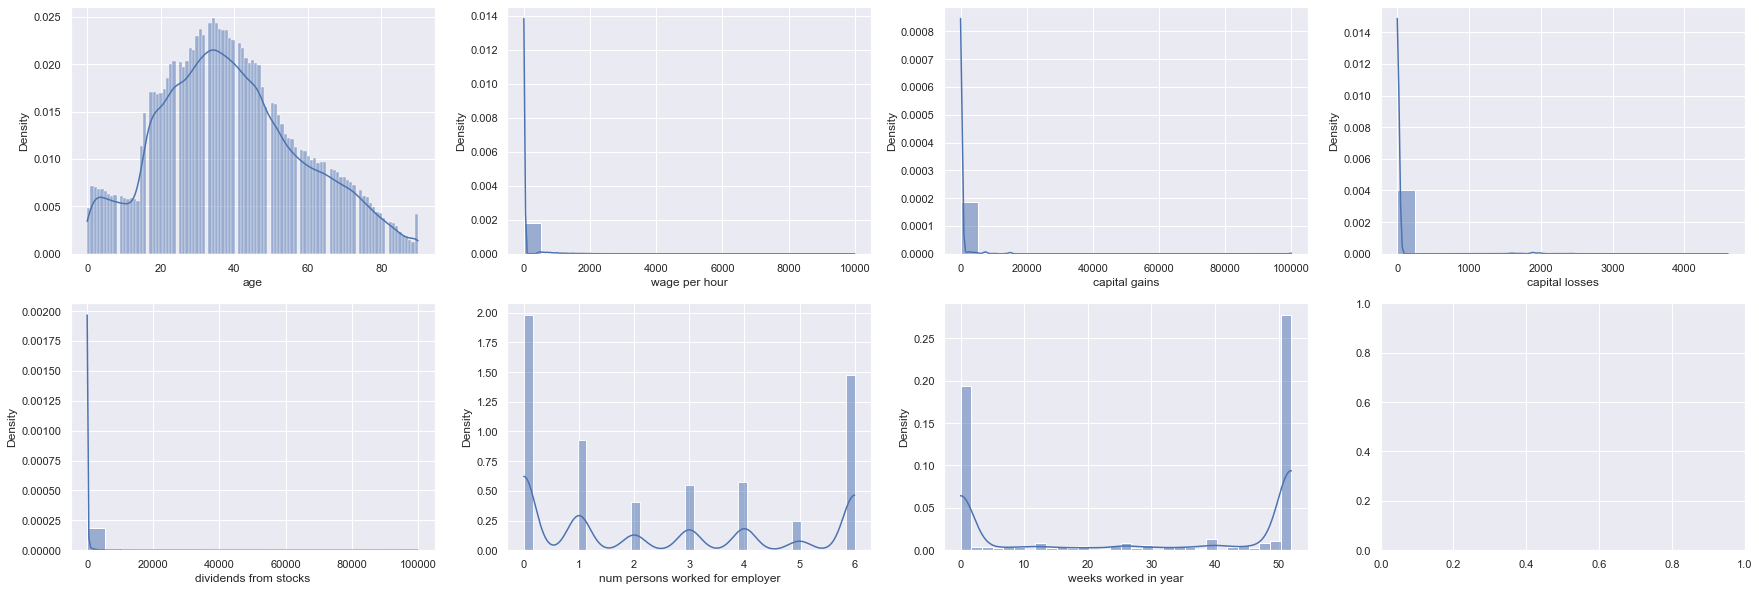

In [46]:
# Show density plot for all the continuous variables
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(30, 10))
for i, col in enumerate(num_cols):
    sns.histplot(data, x=col, stat="density", kde=True, ax=axs.flatten()[i])

In [47]:
print("RATE OF ZERO VALUES")
for col in num_cols:
    print("- ", col, " : ", 100*round((data[col] == 0).sum()/len(data),2),"%")

RATE OF ZERO VALUES
-  age  :  0.0 %
-  wage per hour  :  93.0 %
-  capital gains  :  95.0 %
-  capital losses  :  97.0 %
-  dividends from stocks  :  86.0 %
-  num persons worked for employer  :  32.0 %
-  weeks worked in year  :  32.0 %


- **Age** : a rather nice gaussian (-ish) distribution. We probably won't have to wrangle much with this feature

- **Wage per hour, capital gains, capital losses, dividends from stocks** : these are **highly skewed** distributions with an overwhelmingly large number of zeros (between 86 and 97% of observations). We might consider dropping these features later on or, alternatively, replace them with binary ones (null or not null) if there is the need to reduce overfitting later on

- **Num persons worked for employer** : the plot makes it obvious that the initial range of wages has been mapped to a discrete set of values. While we could treat this as a categorical variable, the documentation indicates that the higher the assigned value, the higher the number of people working for employer. We can therefore keep it as it is.

- **Weeks worked in year** : we can see a U-shaped distribution. One the left side, the population might correspond to either children, pensioners or unemployed adults (which seems to be corroborated by the plot below). This feature could also be mapped to a binary variable (worked / did not work this year).

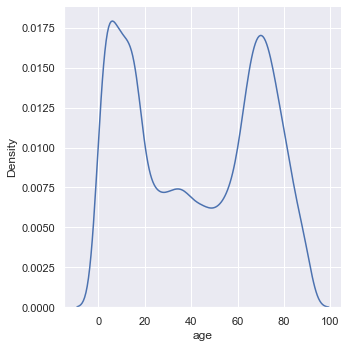

In [48]:
# This plot shows the age distribution for people who did not work during the year but are not identified as 'unemployed' either
sns.displot(data[(data["weeks worked in year"] == 0) & (data["reason for unemployment"] == "Not in universe")], x="age", kind="kde")

##### **1.5 : Distribution of categorical features

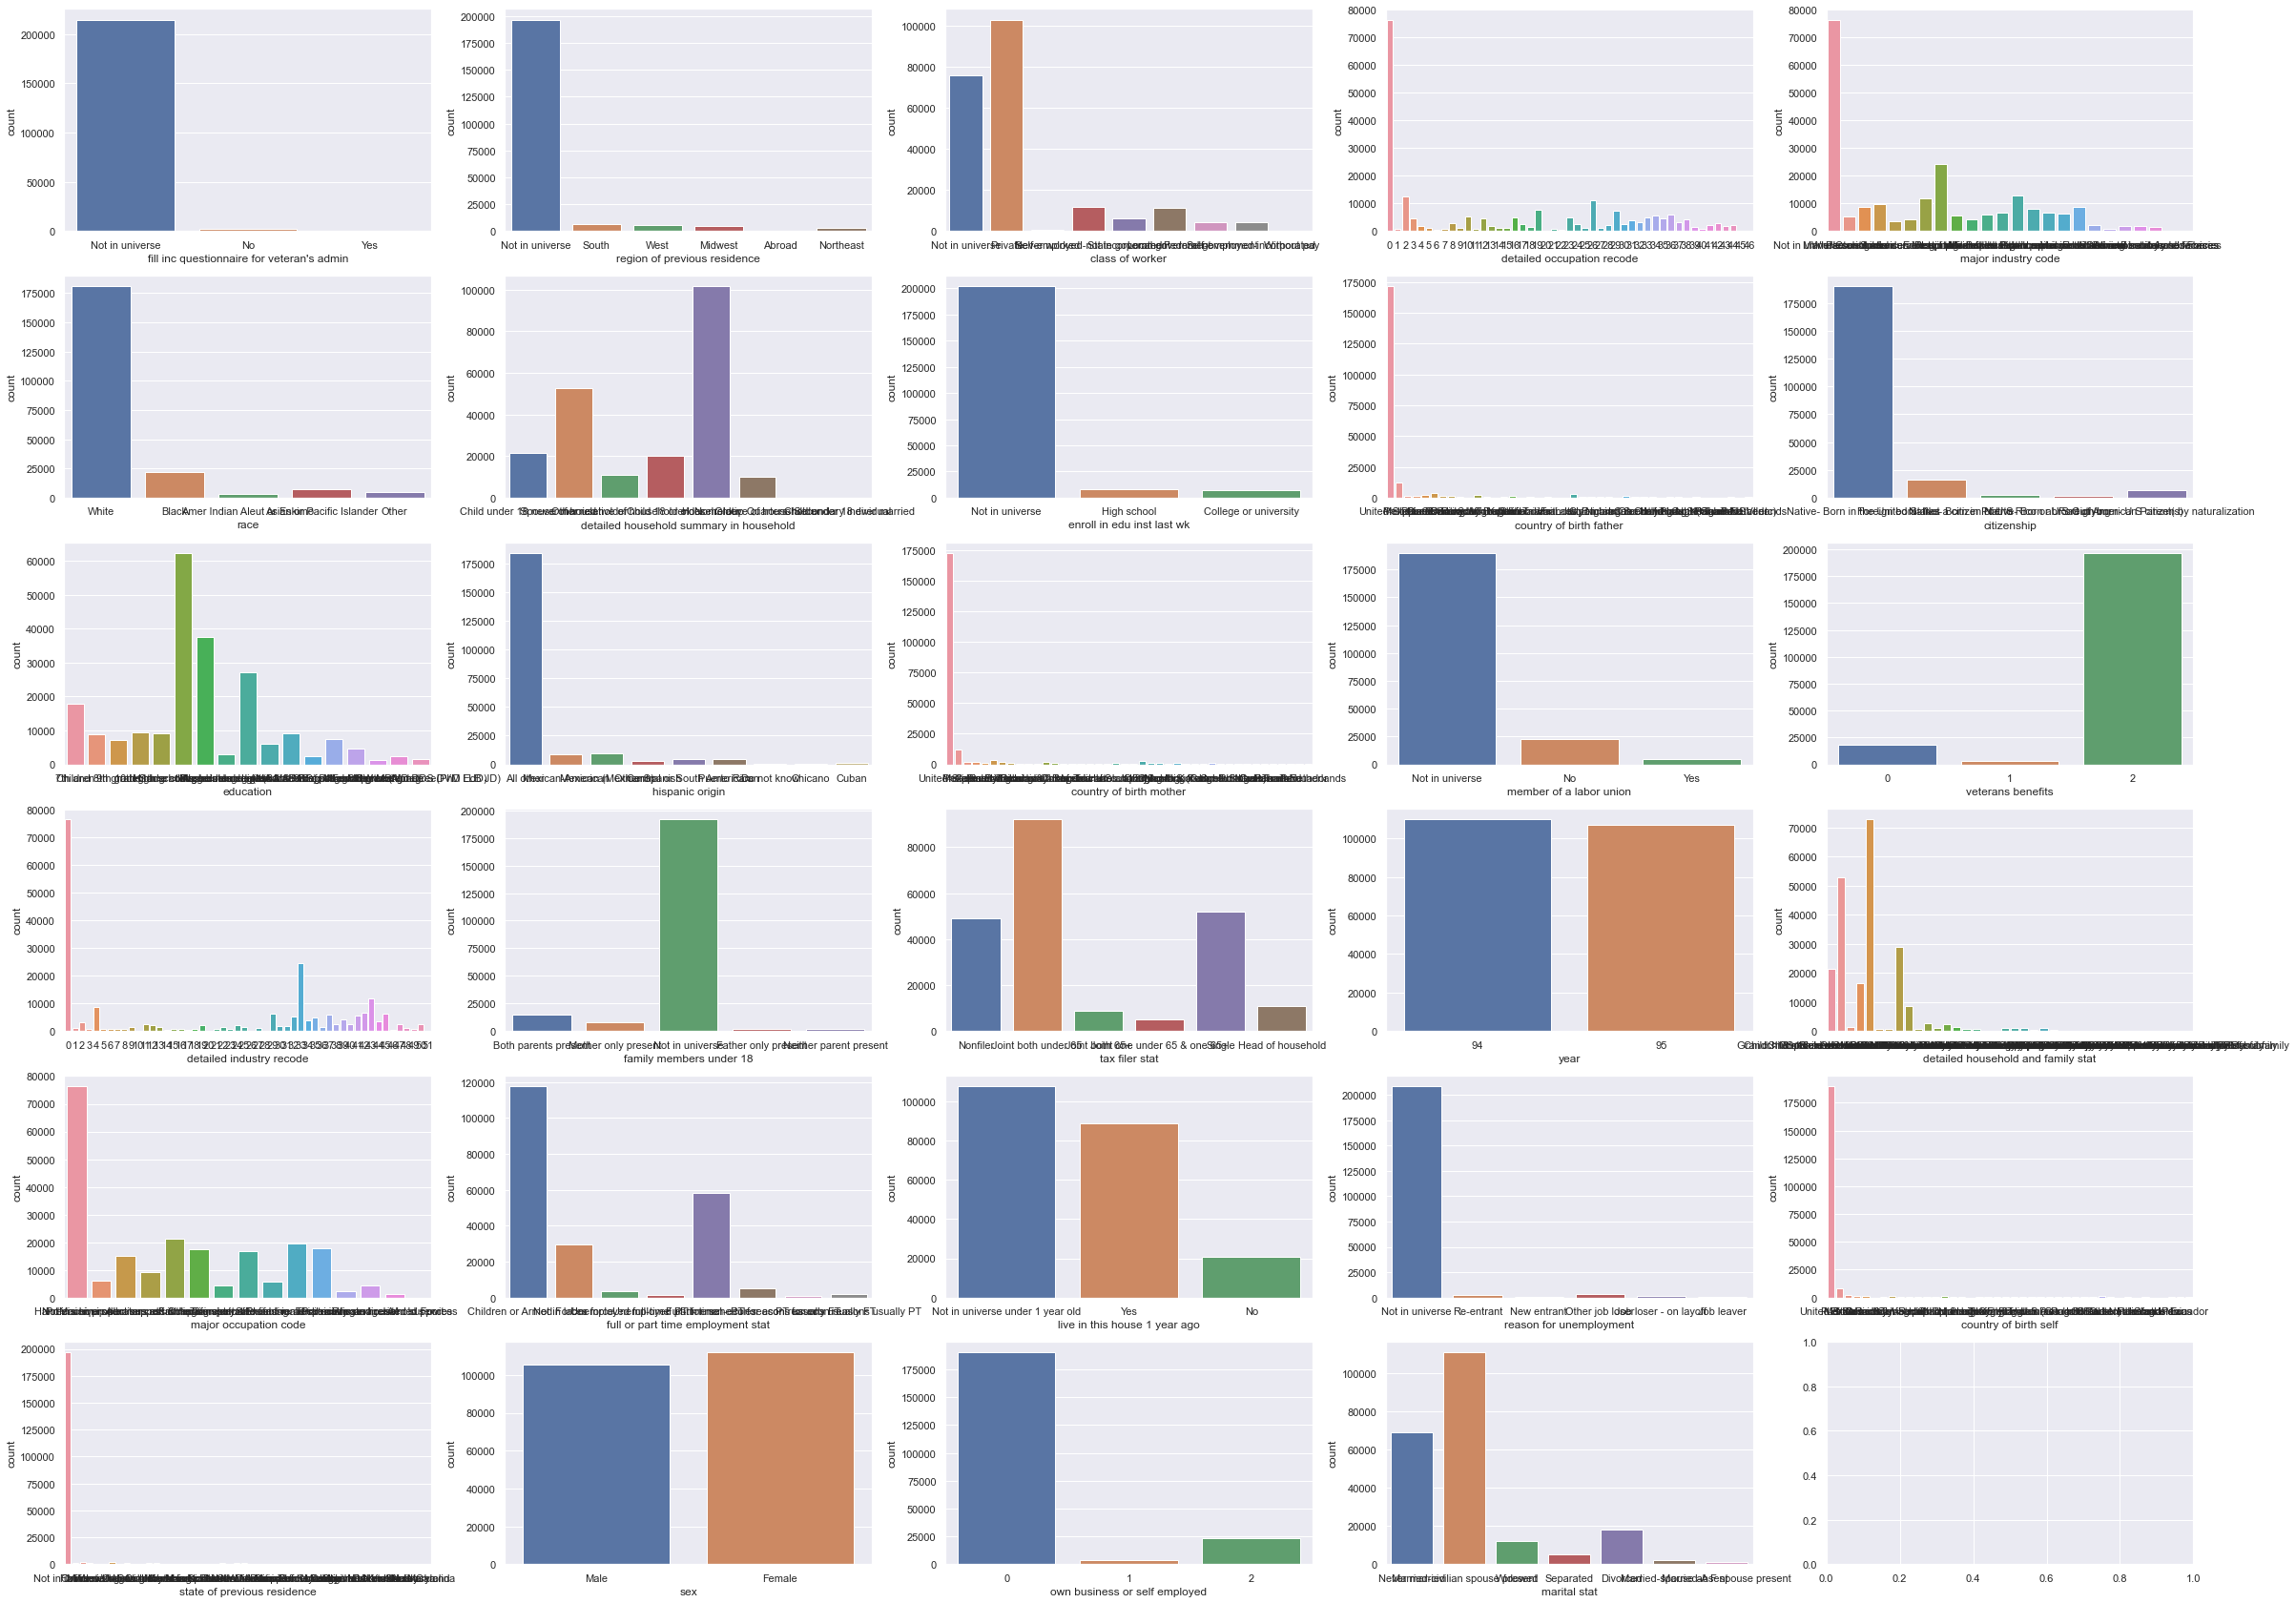

In [49]:
# Show bar charts for categorical features distribution
fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(40, 30))
for i, col in enumerate(cat_cols):
    sns.countplot(data=data, x=col, ax=axs.flatten()[i])

- Some of these features are heavily unbalanced. To avoid ending up with a too large number of features when encoding later on, we could regroup all categories with frequency lower than an arbitrary threshold (for example 5%, which would be all categories below ~11k observations on the plots above)

- Additionnally, it is worth noting that the imbalance is too extreme in certain cases, which could lead to simply get rid of the features ("state of previous residence", for example)

##### **1.6 : Dependency between continous variables**

We can check correlation between continuous variables using pearson's coefficient (as seen before, the "number of employees" feature should be treated separately because it has been mapped to a discrete set of values)

<AxesSubplot:>

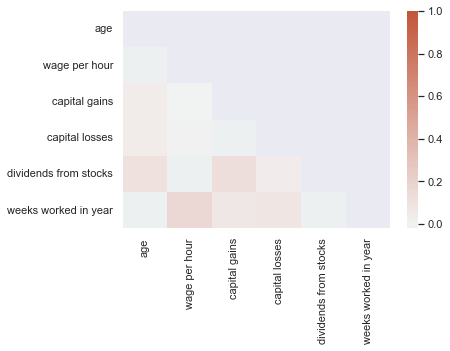

In [25]:
# Check correlation coefficient between continous variables
import numpy as np

corr = data[[col for col in num_cols if col != "num persons worked for employer"]].corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0, vmax=1, mask=mask)

There is no evidence of correlation between these features.

##### **1.7 : Relationships between target and variables**

In [95]:
# Separating dataset based on output category
data_under50 = data[data["total person income"] == "- 50000."]
data_over50 = data[data["total person income"] == "50000+."]

In [42]:
# Distribution of target classes
print("Under 50k : " + str(len(data_under50)/len(data)))
print("Over 50k : " + str(len(data_over50)/len(data)))

Under 50k : 0.9204603451209027
Over 50k : 0.07953965487909734


As we saw earlier, we are dealing with imbalanced classes, as we have a much lower representation of the "high income" class. This is something that we will have to take into account in the modelling process later on. In particular we could :
- Pick an appropriate evaluation metric, like F1 score, rather than accuracy (a dummy model predicting the majority class 100% of the time would have 92% accuracy)
- Make use of undersampling or oversampling to rebalance our dataset

To check for relationships between target and continuous variables, we can simply compare density plots among the two classes

Note : we will exclude "num persons worked for employer" as it has been mapped to a discrete set of values

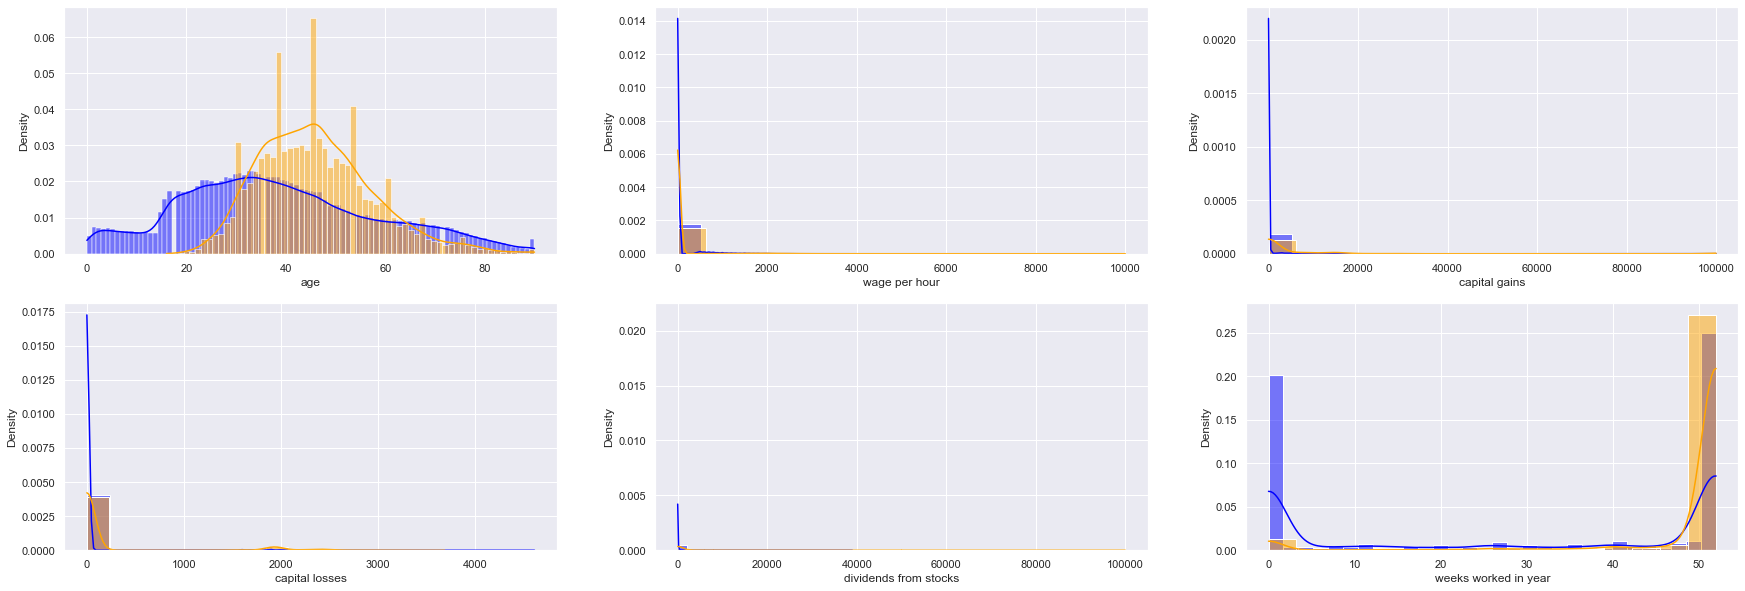

In [96]:
features_to_compare = [col for col in num_cols if col != "num persons worked for employer"]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30, 10))
for i, col in enumerate(features_to_compare):
    sns.histplot(data_under50, x=col, stat="density", kde=True, label="Under 50k", color="blue", ax=axs.flatten()[i])
    sns.histplot(data_over50, x=col, stat="density", kde=True, label="Over 50k", color="orange", ax=axs.flatten()[i])

We can make the following observations :

- **Age** : this feature seems to be able to discriminate the two classes pretty well. In particular, individuals between 0 and ~20 belong exclusively to the "low income" class
- **Weeks worked in year** : as could also be expected, probability of being under 50k is much more important for individuals who did not work during the year. Aside from that, we can really say much more from the plot, because of overlap.
- **Other features** : the overwhelmingly high number of zeros makes it hard to conclude on a relationship. However, we could try converting them into binary classes ("not null"/"null") and looking at heatmaps

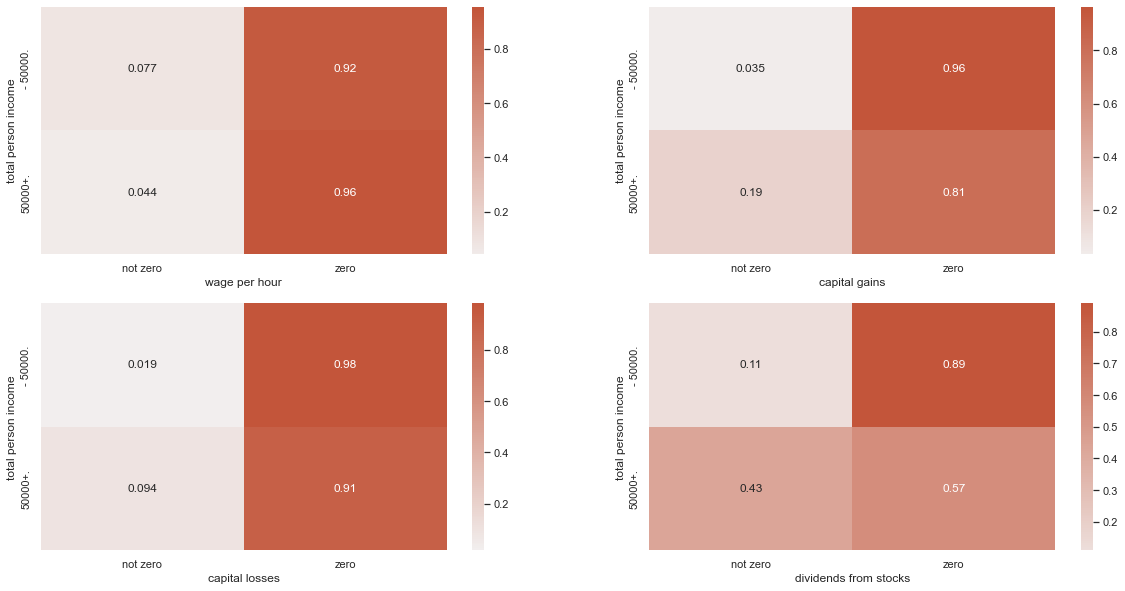

In [97]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
for i, col in enumerate(["wage per hour", "capital gains", "capital losses", "dividends from stocks"]):
    tab = pd.crosstab(data["total person income"], data[col].map(lambda val: "not zero" if val > 0 else "zero"))
    tab = tab.apply(lambda row: row/row.sum(), axis=1)
    sns.heatmap(tab, annot=True, ax=axs.flatten()[i], cmap=cmap, center=0)

Because of heavy class imbalance, we looked at the proportion of each of the two categories **within each class**, rather than just counting occurences for each of the 4 combinations.

- From wage per hour and capital losses, we cannot conclude much.

- However, for capital gains and dividends from stocks, non-null values are significantly more frequent among the "high income" class than in the "low income" class

We can perform some ANOVA tests to look for highest dependencies (or indenpendencies) between our target and features

In [110]:
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(data[num_cols])
y = data["total person income"].map(lambda s: 0 if "-" in s else 1)
fstat, pval = f_classif(X, y)

pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_num = pd.DataFrame(columns=data[num_cols].columns, data=[fstat, pval], index=["score", "pval"]).transpose()
df_num.sort_values("score", ascending=False)


,score,pval
capital gains,12815.759,0.000
weeks worked in year,11539.483,0.000
num persons worked for employer,7574.089,0.000
dividends from stocks,6715.496,0.000
capital losses,4264.118,0.000
age,2218.843,0.000
wage per hour,12.676,0.000


From the above table, we can see that the p-values are low enough so we can discard the hypothethis of independance between any of these features and the target variable.

Let us now check for dependancies between our target and the rest of the features (categorical). Since there are a lot, we won't plot all of them. Let's start by performing chi2 tests

In [111]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import OrdinalEncoder

X = OrdinalEncoder().fit_transform(data[cat_cols])
y = data["total person income"].map(lambda s: 0 if "-" in s else 1)
chi, pval = chi2(X, y)


df_cat = pd.DataFrame(columns=data[cat_cols].columns, data=[chi, pval], index=["score", "pval"]).transpose()
df_cat.sort_values("score", ascending=False)


,score,pval
detailed industry recode,78479.449,0.000
detailed occupation recode,8224.323,0.000
hispanic origin,7402.586,0.000
education,3969.421,0.000
sex,3534.538,0.000
marital stat,2495.073,0.000
tax filer stat,2054.010,0.000
major industry code,1458.384,0.000
major occupation code,1210.807,0.000
detailed household and family stat,1130.907,0.000


Right away, we can spot the bottom three features having high p-values. We can therefore assume that they are independant from our target variable, meaning we could probably get rid of them.

On the opposite side of the table, let us take a closer look at the distribution within each target class for some of the highest scoring features (top 5 for instance)

In [164]:
# For the sake of clarity, we will rearrange education labels by academic level
education_ranked = [
    "Children", "Less than 1st grade", "1st 2nd 3rd or 4th grade", "5th or 6th grade", "7th and 8th grade", "9th grade", "10th grade", "11th grade", "12th grade no diploma",
    "High school graduate", "Some college but no degree", "Associates degree-occup /vocational", "Associates degree-academic program",
    "Bachelors degree(BA AB BS)", "Masters degree(MA MS MEng MEd MSW MBA)", "Prof school degree (MD DDS DVM LLB JD)", "Doctorate degree(PhD EdD)"
]

data_under50["education"] = pd.Categorical(data_under50["education"], education_ranked)
data_over50["education"] = pd.Categorical(data_over50["education"], education_ranked)

C:\Users\Bonzy\AppData\Local\Temp/ipykernel_18988/688830277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_under50["education"] = pd.Categorical(data_under50["education"], education_ranked)
C:\Users\Bonzy\AppData\Local\Temp/ipykernel_18988/688830277.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_over50["education"] = pd.Categorical(data_over50["education"], education_ranked)


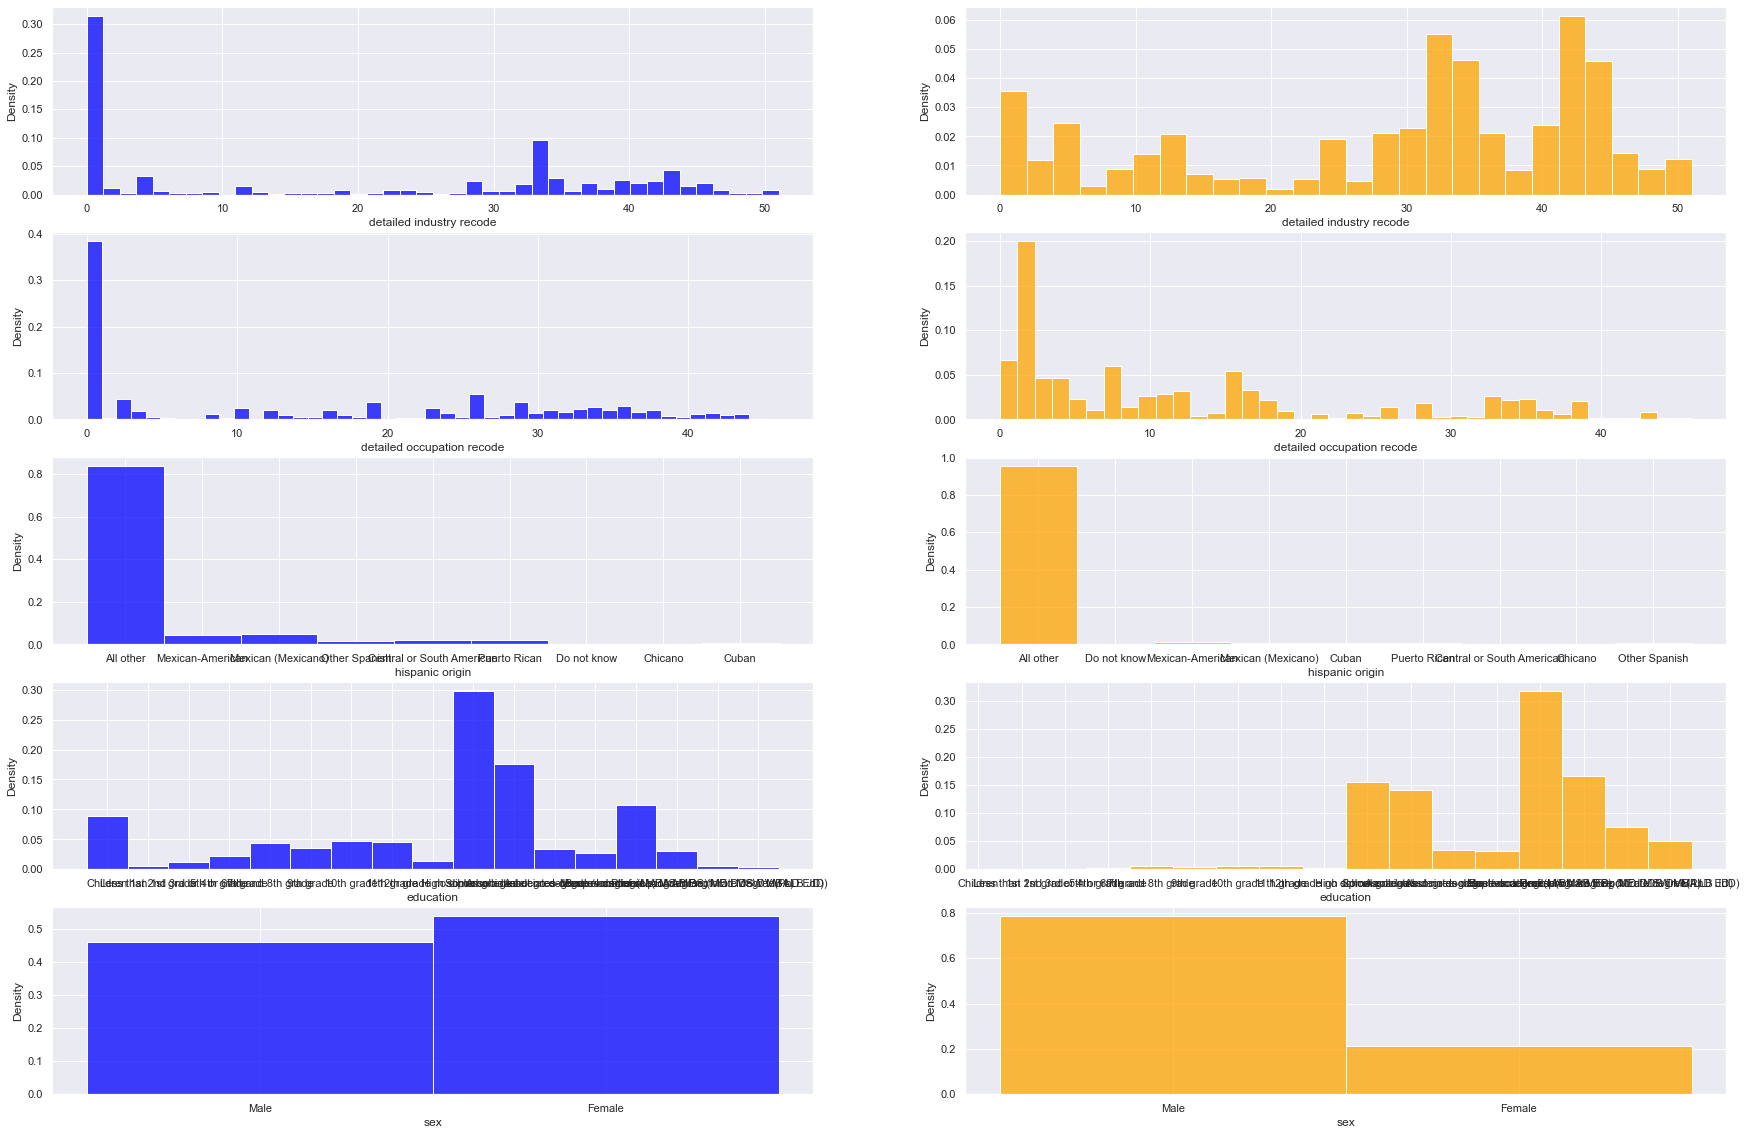

In [159]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(30,20))
for i, col in enumerate(df_cat.sort_values("score", ascending=False)[:5].index):
    sns.histplot(data=data_under50, x=col, stat="density", ax=axs.flatten()[2*i], color="blue")
    sns.histplot(data=data_over50, x=col, stat="density", ax=axs.flatten()[2*i+1], color="orange")


We can indeed spot rather different distributions between the "low income" class (blue) and "high income" class". Specifically, we can see that :
- Income levels strongly depends on the field of work ("industry recode") and the type of work ("occupation recode"), though we cannot say which ones because of encoding
- There is almost no representation of hispanic people among the "high income" class
- The educational level of high income individuals is (almost) always at least 12th grade, meaning that they completed high school (but did not necessarily graduate). The likelihood of belonging to the low income class is very strong beneath that level. Above bachelor's degree, it is the opposite.
- Women are largely underrepresented within the high income class

___
### Key points before diving into modelling

- Account for target class imbalance by using f1-score and, possibly, performing oversampling
- Get rid of features with too many missing values (migration code-change in msa, migration code-change in reg,migration code-move within reg, migration prev res in sunbelt)
- Get rid of features that were tested independant from the target variable (fill inc questionnaire for veteran's admin, reason for unemployment, region of previous residence)
- Perform feature engineering if necessary to improve predictive power. These must be interpretable features (as opposed to polynomial features for instance) 
- Work with interpretable models, such as regression-based models or decision-trees, from which we can deduce feature importance *a posteriori*